In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

print("Notebook imports OK")


Notebook imports OK


In [3]:
from dataclasses import dataclass

@dataclass
class PositionLiquidityGuard:
    max_gross_exposure: float
    target_risk: float
    volatility_baseline: float
    max_leverage: float
    liquidity_floor: float
    min_position_fraction: float

    def _shock_throttle(self, vol: float) -> float:
        """
        Simple, reliable shock throttle:
        - <= baseline: 1.0  (no throttle)
        - >  baseline: (baseline / vol)^2  (fast decay)
        Clipped to [0, 1].
        """
        if vol <= 0:
            return 0.0
        if vol <= self.volatility_baseline:
            return 1.0
        ratio = self.volatility_baseline / vol
        throttle = ratio ** 2
        return float(max(0.0, min(1.0, throttle)))

    def _effective_leverage(self, vol: float) -> float:
        """
        Leverage also decays with volatility:
        - <= baseline: max_leverage
        - >  baseline: max_leverage * min(1, baseline / vol)
        """
        if vol <= 0:
            return 0.0
        if vol <= self.volatility_baseline:
            return float(self.max_leverage)
        ratio = self.volatility_baseline / vol
        lev = self.max_leverage * min(1.0, ratio)
        return float(max(0.0, lev))

    def compute_position(self, raw_signal: float, vol: float, liquidity_score: float) -> float:
        """
        Combine:
        - raw signal
        - volatility shock throttle
        - volatility-dependent leverage
        - liquidity_score (floored at liquidity_floor)
        - hard cap by max_gross_exposure
        - small positions under min_position_fraction are zeroed
        """
        # sanitize liquidity
        liq = float(max(self.liquidity_floor, min(1.0, liquidity_score)))

        throttle = self._shock_throttle(vol)
        lev = self._effective_leverage(vol)

        pos = raw_signal * liq * throttle * lev

        # cap by gross exposure, scaled by liquidity
        max_pos = self.max_gross_exposure * liq
        pos = max(-max_pos, min(max_pos, pos))

        # prune tiny dust positions
        if abs(pos) < self.min_position_fraction * max_pos:
            pos = 0.0

        return float(pos)


In [4]:
guard = PositionLiquidityGuard(
    max_gross_exposure=1.0,
    target_risk=0.02,
    volatility_baseline=0.02,
    max_leverage=2.0,
    liquidity_floor=0.25,
    min_position_fraction=0.05,
)

guard



PositionLiquidityGuard(max_gross_exposure=1.0, target_risk=0.02, volatility_baseline=0.02, max_leverage=2.0, liquidity_floor=0.25, min_position_fraction=0.05)

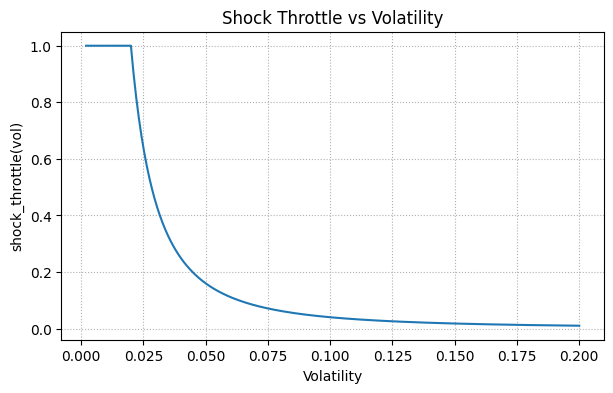

In [5]:
vols = np.linspace(0.002, 0.20, 375)
throttles = [guard._shock_throttle(v) for v in vols]

plt.figure(figsize=(7, 4))
plt.title("Shock Throttle vs Volatility")
plt.xlabel("Volatility")
plt.ylabel("shock_throttle(vol)")
plt.plot(vols, throttles)
plt.grid(True, linestyle=":")
plt.show()


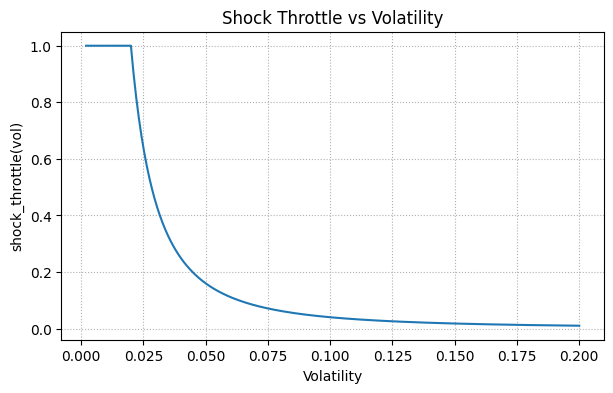

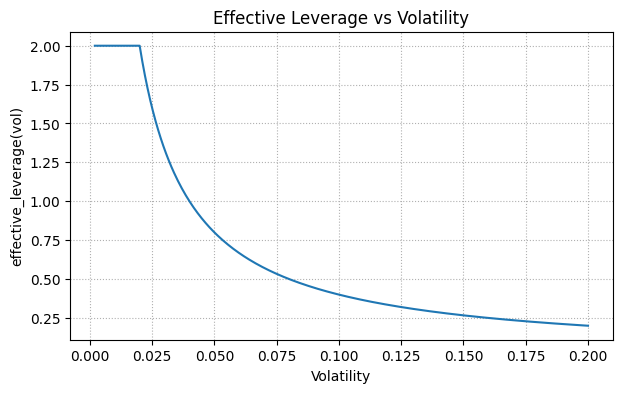

In [6]:
vols = np.linspace(0.002, 0.20, 375)

throttles = [guard._shock_throttle(v) for v in vols]
leverages = [guard._effective_leverage(v) for v in vols]

# Throttle curve
plt.figure(figsize=(7, 4))
plt.title("Shock Throttle vs Volatility")
plt.xlabel("Volatility")
plt.ylabel("shock_throttle(vol)")
plt.plot(vols, throttles)
plt.grid(True, linestyle=":")
plt.show()

# Leverage curve
plt.figure(figsize=(7, 4))
plt.title("Effective Leverage vs Volatility")
plt.xlabel("Volatility")
plt.ylabel("effective_leverage(vol)")
plt.plot(vols, leverages)
plt.grid(True, linestyle=":")
plt.show()


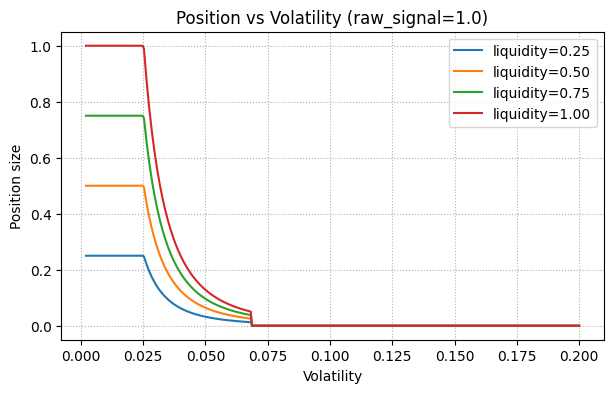

In [7]:
vols = np.linspace(0.002, 0.20, 375)
liquidity_levels = [0.25, 0.5, 0.75, 1.0]
raw_signal = 1.0

plt.figure(figsize=(7, 4))
plt.title(f"Position vs Volatility (raw_signal={raw_signal})")
plt.xlabel("Volatility")
plt.ylabel("Position size")

for liq in liquidity_levels:
    positions = [guard.compute_position(raw_signal, v, liq) for v in vols]
    plt.plot(vols, positions, label=f"liquidity={liq:.2f}")

plt.grid(True, linestyle=":")
plt.legend()
plt.show()


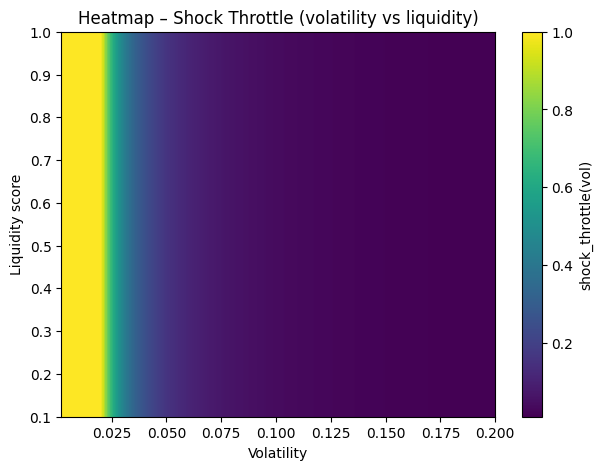

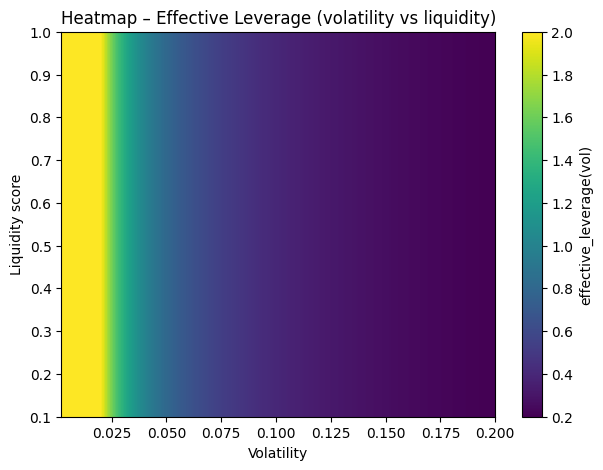

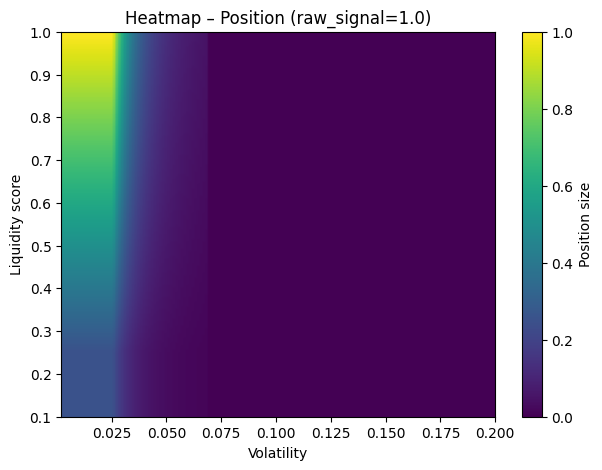

In [8]:
vol_grid = np.linspace(0.002, 0.20, 160)
liq_grid = np.linspace(0.1, 1.0, 160)
V, L = np.meshgrid(vol_grid, liq_grid)

# Throttle heatmap
T = np.zeros_like(V)
for i in range(L.shape[0]):
    for j in range(V.shape[1]):
        T[i, j] = guard._shock_throttle(V[i, j])

plt.figure(figsize=(7, 5))
plt.title("Heatmap – Shock Throttle (volatility vs liquidity)")
plt.xlabel("Volatility")
plt.ylabel("Liquidity score")
im = plt.imshow(
    T,
    origin="lower",
    extent=[vol_grid.min(), vol_grid.max(), liq_grid.min(), liq_grid.max()],
    aspect="auto",
)
plt.colorbar(im, label="shock_throttle(vol)")
plt.show()

# Leverage heatmap
E = np.zeros_like(V)
for i in range(L.shape[0]):
    for j in range(V.shape[1]):
        E[i, j] = guard._effective_leverage(V[i, j])

plt.figure(figsize=(7, 5))
plt.title("Heatmap – Effective Leverage (volatility vs liquidity)")
plt.xlabel("Volatility")
plt.ylabel("Liquidity score")
im = plt.imshow(
    E,
    origin="lower",
    extent=[vol_grid.min(), vol_grid.max(), liq_grid.min(), liq_grid.max()],
    aspect="auto",
)
plt.colorbar(im, label="effective_leverage(vol)")
plt.show()

# Position heatmap
raw_signal = 1.0
P = np.zeros_like(V)
for i in range(L.shape[0]):
    for j in range(V.shape[1]):
        P[i, j] = guard.compute_position(raw_signal, V[i, j], L[i, j])

plt.figure(figsize=(7, 5))
plt.title(f"Heatmap – Position (raw_signal={raw_signal})")
plt.xlabel("Volatility")
plt.ylabel("Liquidity score")
im = plt.imshow(
    P,
    origin="lower",
    extent=[vol_grid.min(), vol_grid.max(), liq_grid.min(), liq_grid.max()],
    aspect="auto",
)
plt.colorbar(im, label="Position size")
plt.show()


In [9]:
# 3D grid
vol_grid = np.linspace(0.002, 0.20, 80)
liq_grid = np.linspace(0.1, 1.0, 80)
V, L = np.meshgrid(vol_grid, liq_grid)


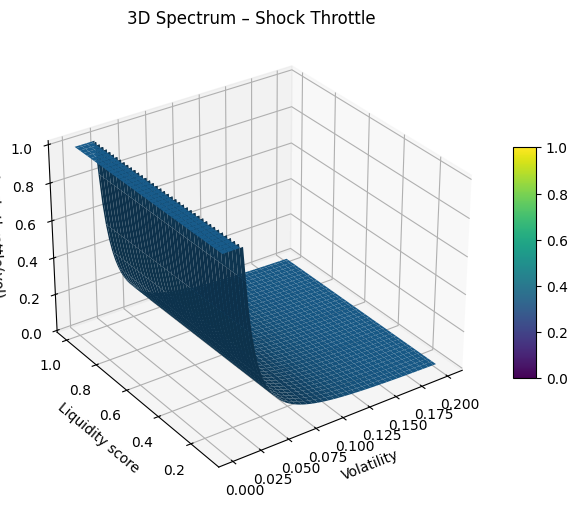

In [10]:
# 3D – Shock Throttle surface
Z_throttle = np.zeros_like(V)
for i in range(L.shape[0]):
    for j in range(V.shape[1]):
        Z_throttle[i, j] = guard._shock_throttle(V[i, j])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=30, azim=235)

surf = ax.plot_surface(V, L, Z_throttle, linewidth=0, antialiased=True)
ax.set_title("3D Spectrum – Shock Throttle")
ax.set_xlabel("Volatility")
ax.set_ylabel("Liquidity score")
ax.set_zlabel("shock_throttle(vol)")
fig.colorbar(surf, shrink=0.5, aspect=10, ax=ax)
plt.show()


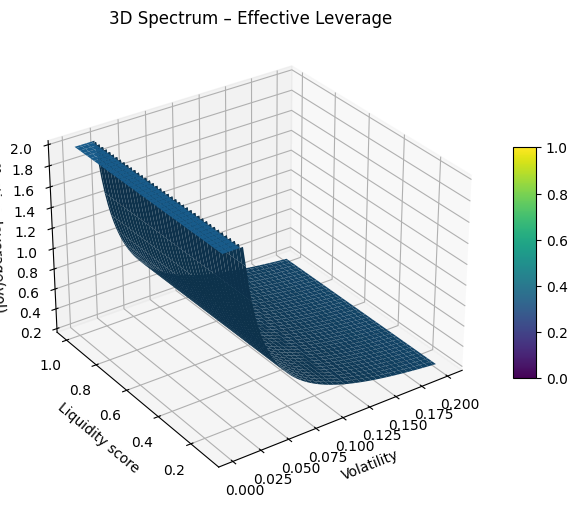

In [11]:
# 3D – Effective Leverage surface
Z_lev = np.zeros_like(V)
for i in range(L.shape[0]):
    for j in range(V.shape[1]):
        Z_lev[i, j] = guard._effective_leverage(V[i, j])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=30, azim=235)

surf = ax.plot_surface(V, L, Z_lev, linewidth=0, antialiased=True)
ax.set_title("3D Spectrum – Effective Leverage")
ax.set_xlabel("Volatility")
ax.set_ylabel("Liquidity score")
ax.set_zlabel("effective_leverage(vol)")
fig.colorbar(surf, shrink=0.5, aspect=10, ax=ax)
plt.show()


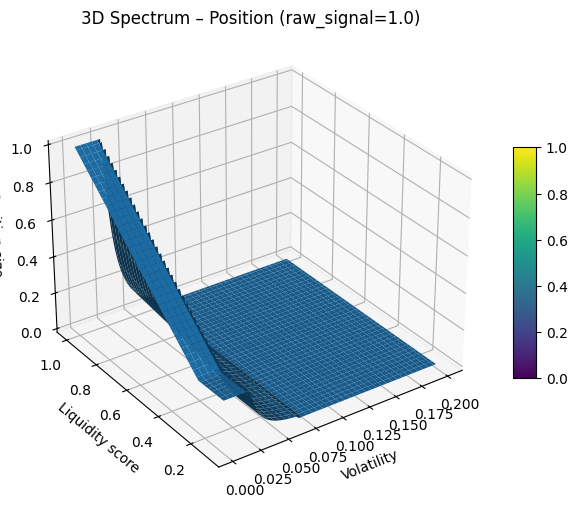

In [12]:
# 3D – Position surface
raw_signal = 1.0
Z_pos = np.zeros_like(V)
for i in range(L.shape[0]):
    for j in range(V.shape[1]):
        Z_pos[i, j] = guard.compute_position(raw_signal, V[i, j], L[i, j])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=30, azim=235)

surf = ax.plot_surface(V, L, Z_pos, linewidth=0, antialiased=True)
ax.set_title(f"3D Spectrum – Position (raw_signal={raw_signal})")
ax.set_xlabel("Volatility")
ax.set_ylabel("Liquidity score")
ax.set_zlabel("Position size")
fig.colorbar(surf, shrink=0.5, aspect=10, ax=ax)
plt.show()


In [13]:
def compute_position_simplified(raw_signal, vol, liquidity, guard):
    liq = float(max(guard.liquidity_floor, min(1.0, liquidity)))
    throttle = guard._shock_throttle(vol)
    lev = guard._effective_leverage(vol)
    # 只做简单乘法 + max_gross_exposure，不剪小仓位
    pos = raw_signal * liq * throttle * lev
    max_pos = guard.max_gross_exposure * liq
    pos = max(-max_pos, min(max_pos, pos))
    return float(pos)


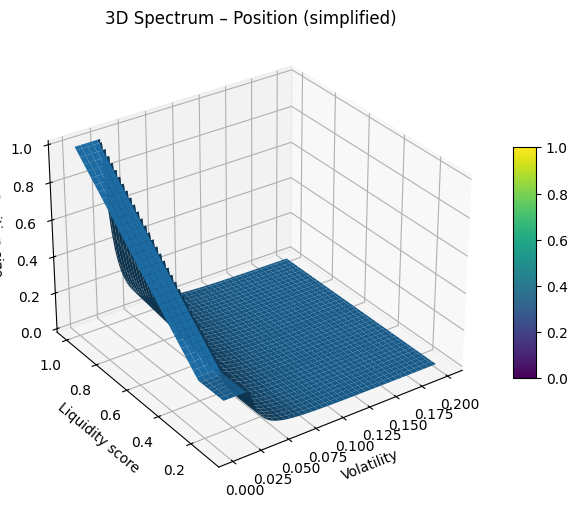

In [14]:
vol_grid = np.linspace(0.002, 0.20, 80)
liq_grid = np.linspace(0.1, 1.0, 80)
V, L = np.meshgrid(vol_grid, liq_grid)

Z_simple = np.zeros_like(V)
raw_signal = 1.0
for i in range(L.shape[0]):
    for j in range(V.shape[1]):
        Z_simple[i, j] = compute_position_simplified(raw_signal, V[i, j], L[i, j], guard)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=30, azim=235)
surf = ax.plot_surface(V, L, Z_simple, linewidth=0, antialiased=True)
ax.set_title("3D Spectrum – Position (simplified)")
ax.set_xlabel("Volatility")
ax.set_ylabel("Liquidity score")
ax.set_zlabel("Position size")
fig.colorbar(surf, shrink=0.5, aspect=10, ax=ax)
plt.show()
